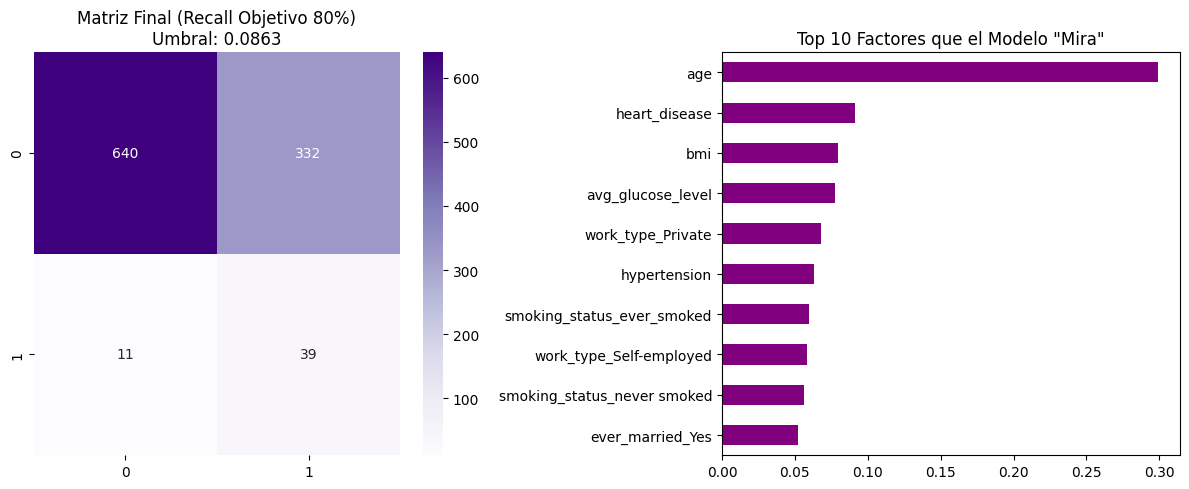

              precision    recall  f1-score   support

           0       0.98      0.66      0.79       972
           1       0.11      0.78      0.19        50

    accuracy                           0.66      1022
   macro avg       0.54      0.72      0.49      1022
weighted avg       0.94      0.66      0.76      1022



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1. CARGA Y FEATURE ENGINEERING
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')

def engineer_features(df_input):
    df_new = df_input.copy()
    # Categorías Médicas
    df_new['age_group'] = pd.cut(df_new['age'], bins=[0, 18, 45, 60, 100], labels=['Child', 'Adult', 'Senior', 'Critical_Risk'])
    df_new['bmi_cat'] = pd.cut(df_new['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    df_new['glucose_cat'] = pd.cut(df_new['avg_glucose_level'], bins=[0, 100, 125, 300], labels=['Normal', 'Prediabetes', 'Diabetes'])
    
    # Dummies
    cols_to_dummy = ['age_group', 'bmi_cat', 'glucose_cat', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    return pd.get_dummies(df_new, columns=cols_to_dummy, drop_first=True)

df_final = engineer_features(df)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. ENTRENAMIENTO
model = XGBClassifier(n_estimators=125, learning_rate=0.1, max_depth=5, scale_pos_weight=19.4, random_state=42)
model.fit(X_train, y_train)

# 3. APLICAR EL UMBRAL ÓPTIMO ENCONTRADO (0.0863)
umbral_final = 0.0863
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs >= umbral_final).astype(int)

# 4. RESULTADOS FINALES
plt.figure(figsize=(12, 5))

# Matriz de Confusión
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Purples')
plt.title(f'Matriz Final (Recall Objetivo 80%)\nUmbral: {umbral_final}')

# Importancia de Variables
plt.subplot(1, 2, 2)
pd.Series(model.feature_importances_, index=X.columns).nlargest(10).sort_values().plot(kind='barh', color='purple')
plt.title('Top 10 Factores que el Modelo "Mira"')

plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_final))